In [1]:
import pandas as pd
import numpy as np
import math
import joblib

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('../data/train_test_sets/train.csv', index_col = 'CASRN')
test = pd.read_csv('../data/train_test_sets/test.csv', index_col = 'CASRN')

In [3]:
train.head(1)

,EPA_category,GHS_category,LD50_mgkg,nontoxic,very_toxic,SMILES
CASRN,,,,,,
23233-88-7,3.0,5.0,3000.0,True,False,CC(=O)Oc1c(Br)cc(Cl)cc1C(=S)Nc1ccc(Br)cc1


In this study, we have five endpoints: 
 - (1) EPA category (class 1-4), 
 - (2) GHS category (class 1-5), 
 - (3) LD50 (mg/kg/day); 
 - (4) nontoxic (LD50 >2,000 mg/kg)
 - (5) very toxic (LD50 < 50 mg/kg)
 

We will make some adjustment on the labels for modeling 
 - (1) change LD50_mgkg to LD50 mmolkg
 - (2) change 'nontoxic' to 'toxic' (switch the True and False)
 - (3) label encoding the classifiation labels

In [4]:
PandasTools.AddMoleculeColumnToFrame(train,smilesCol='SMILES')
PandasTools.AddMoleculeColumnToFrame(test,smilesCol='SMILES')

In [5]:
train['MW'] = train.apply(lambda x: Descriptors.MolWt(x['ROMol']), axis=1)
test['MW'] = test.apply(lambda x: Descriptors.MolWt(x['ROMol']), axis=1)

,EPA_category,GHS_category,LD50_mgkg,nontoxic,very_toxic,SMILES,ROMol,MW
CASRN,,,,,,,,
23233-88-7,3.0,5.0,3000.0,True,False,CC(=O)Oc1c(Br)cc(Cl)cc1C(=S)Nc1ccc(Br)cc1,,463.578

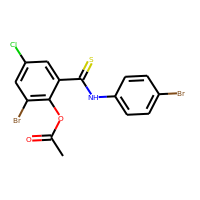

In [6]:
train.head(1)

In [7]:
def logLD50(df):
    logLD50_mmolkg = []
    for i in range(df.shape[0]):
        if pd.isna(df['LD50_mgkg'][i]):
            logLD50_mmolkg.append(df['LD50_mgkg'][i])
        else:
            logLD50_mmolkg.append(math.log10(float(df['LD50_mgkg'][i])/float(df['MW'][i])))
    return logLD50_mmolkg

In [8]:
train['logLD50_mmolkg'] = logLD50(train)
test['logLD50_mmolkg'] = logLD50(test)

,EPA_category,GHS_category,LD50_mgkg,nontoxic,very_toxic,SMILES,ROMol,MW,logLD50_mmolkg
CASRN,,,,,,,,,
23233-88-7,3.0,5.0,3000.0,True,False,CC(=O)Oc1c(Br)cc(Cl)cc1C(=S)Nc1ccc(Br)cc1,,463.578,0.810998

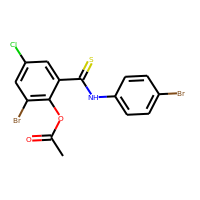

In [9]:
train.head(1)

In [10]:
def binary_toxic(df):
    toxic = []
    for i in range(df.shape[0]):
        if pd.isna(df['nontoxic'][i]):
            toxic.append(df['nontoxic'][i])
        else:
            toxic.append(1 if df['nontoxic'][i] is False else 0)
    return toxic

def binary_verytoxic(df):
    verytoxic = []
    for i in range(df.shape[0]):
        if pd.isna(df['very_toxic'][i]):
            verytoxic.append(df['very_toxic'][i])
        else:
            verytoxic.append(0 if df['very_toxic'][i] is False else 1)
    return verytoxic

In [11]:
train['toxic'] = binary_toxic(train)
test['toxic'] = binary_toxic(test)

In [12]:
train['verytoxic'] = binary_verytoxic(train)
test['verytoxic'] = binary_verytoxic(test)

,EPA_category,GHS_category,LD50_mgkg,nontoxic,very_toxic,SMILES,ROMol,MW,logLD50_mmolkg,toxic,verytoxic
CASRN,,,,,,,,,,,
23233-88-7,3.0,5.0,3000.0,True,False,CC(=O)Oc1c(Br)cc(Cl)cc1C(=S)Nc1ccc(Br)cc1,,463.578,0.810998,0.0,0.0

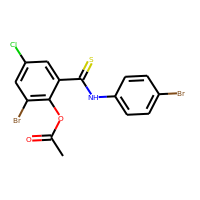

In [13]:
train.head(1)

Drop unnecessary cols

In [14]:
train = train.drop(['nontoxic', 'very_toxic', 'ROMol', 'MW', 'LD50_mgkg'], axis=1)
test = test.drop(['nontoxic', 'very_toxic', 'ROMol', 'MW', 'LD50_mgkg'], axis=1)

In [15]:
train.head(1)

,EPA_category,GHS_category,SMILES,logLD50_mmolkg,toxic,verytoxic
CASRN,,,,,,
23233-88-7,3.0,5.0,CC(=O)Oc1c(Br)cc(Cl)cc1C(=S)Nc1ccc(Br)cc1,0.810998,0.0,0.0


Reorder the cols

In [16]:
columnsTitles = ['SMILES', 'logLD50_mmolkg', 'verytoxic', 'toxic', 'EPA_category', 'GHS_category']

train = train.reindex(columns=columnsTitles)
test = test.reindex(columns=columnsTitles)

In [17]:
train.head(1)

,SMILES,logLD50_mmolkg,verytoxic,toxic,EPA_category,GHS_category
CASRN,,,,,,
23233-88-7,CC(=O)Oc1c(Br)cc(Cl)cc1C(=S)Nc1ccc(Br)cc1,0.810998,0.0,0.0,3.0,5.0


In [18]:
test.head(1)

,SMILES,logLD50_mmolkg,verytoxic,toxic,EPA_category,GHS_category
CASRN,,,,,,
130209-82-4,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,NaN,1.0,1.0,1.0,1.0


In [19]:
train.to_csv('../data/train_test_sets/train_labels.csv')
test.to_csv('../data/train_test_sets/test_labels.csv')

In [25]:
def get_labelencoder(df_labels):
    
    encoder_verytoxic = LabelEncoder().fit(df_labels[~df_labels['verytoxic'].isnull()]['verytoxic'].values)
    encoder_toxic = LabelEncoder().fit(df_labels[~df_labels['toxic'].isnull()]['toxic'].values)
    encoder_epa = LabelEncoder().fit(df_labels[~df_labels['EPA_category'].isnull()]['EPA_category'].values)
    encoder_ghs = LabelEncoder().fit(df_labels[~df_labels['GHS_category'].isnull()]['GHS_category'].values)
    
    return encoder_verytoxic, encoder_toxic, encoder_epa, encoder_ghs

[Label Encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [26]:
encoder_verytoxic, encoder_toxic, encoder_epa, encoder_ghs = get_labelencoder(train)

In [28]:
print('Very toxic', encoder_verytoxic.classes_)
print('Toxic', encoder_toxic.classes_)
print('EPA', encoder_epa.classes_)
print('GHS', encoder_ghs.classes_)

Very toxic [0. 1.]
Toxic [0. 1.]
EPA [1. 2. 3. 4.]
GHS [1. 2. 3. 4. 5.]


Save the encoder for modeling

In [29]:
joblib.dump(encoder_verytoxic, '../data/label_encoders/encoder_verytoxic.joblib')
joblib.dump(encoder_toxic, '../data/label_encoders/encoder_toxic.joblib')
joblib.dump(encoder_epa, '../data/label_encoders/encoder_epa.joblib')
joblib.dump(encoder_ghs, '../data/label_encoders/encoder_ghs.joblib')

['../data/label_encoders/encoder_ghs.joblib']